In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Basic NLP

## Natural Language Processing - NLP

NLP is processing natual language - free text and speech. We can use free text in predictive modelling, in fact it is a quickly developing field.

Technologies such as speech recognition, automatic translation, and computer speech are all based on the concpets that we'll cover here. 

The premise of NLP is that we take a piece of text and process it to transform into a format that we can process. In our case here we'll take free text and convert it into a set of features - we can then use those features to make predictions for our target, just like always!

#### Example Exercise - Spam Filtering

For an example we'll build a spam filter. The dataset here has two columns - one is a text message, the other is a human assigned label of spam or ham. We want to be able to detect the spam messages and filter them out. The only feature we have to be able to do so is the message itself...

# 基礎自然語言處理

## 自然語言處理 - NLP

NLP 正在處理自然語言——自由文本和語音。 我們可以在預測建模中使用自由文本，事實上這是一個快速發展的領域。

語音識別、自動翻譯和計算機語音等技術都基於我們將在此處介紹的概念。

NLP的前提是我們拿一段文本，把它處理成我們可以處理的格式。 

在我們的例子中，我們將獲取自由文本並將其轉換為一組特徵——然後我們可以使用這些特徵對我們的目標進行預測，就像往常一樣！

In [2]:
#Load Data
df = pd.read_csv("data/spam.csv", encoding="ISO-8859-1")
df.drop(columns={"Unnamed: 2", "Unnamed: 3", "Unnamed: 4"}, inplace=True)
df.rename(columns={"v1":"target", "v2":"text"}, inplace=True)
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 特徵構建

與我們習慣的數據不同，我們的自由文本實際上並沒有一組特徵，只有一個特徵包含隨機長度的文本片段。 

將隨機文本消息輸入預測算法不太可能有效。 使用自然文本作為我們預測模型的輸入的第一步是將我們的數據轉換為可用的特徵集，我們可以將其輸入模型。 

這種轉換將導致我們的一維（某種）自由文本變成（可能）非常高維的特徵集。

### 代幣化

轉換數據的第一步是從原始文本中提取每個單詞——這個過程稱為分詞。 Tokenizing 獲取句子並將其轉換為 tolkens 列表——句子中的單詞。

## Feature Construction

Unlike the data that we are used to, our free text doesn't really have a set of features, only one feature that contains random length snipits of text. Feeding in random text messages to a predictive algorithm is unlikely to be effective. The first step in using natural text as an input for our predictive models is to transform our data into a usable feature set that we can feed into a model. This transformation will result in our 1 dimension (kind of) free text turning into a (probably) very high dimension set of features. 

### Tokenization

The first step in transforming the data is to extract each word from the original text - this process is called Tokenizing. Tokenizing takes a sentance and transforms it into a list of tolkens - the words in the sentence. 

![Tokenization](images/tokenization.png "Tokenization")

#### Very Simple Tokenizer

 We can visualize the process of tokenization pretty easily by looking at an example of a dead simple tokenizer. The function below will tokenize a sentence in a basic way - it will chop apart the sentence into words, and add them to a list. This example uses regex to do basic filtering to only extract words that are 2+ letters. 

<b>Note:</b> This example of a tokenizer (and this stuff in general) is a very basic version, and the field of NLP is developing quickly. More advanced text processing is better able to capture more of the structure of the language, and more of the meaning. We are stripping lots of "hidden" meaning out to make it manageable, more advanced NLP tries to understand as much of that meaning as possible. 

#### 非常簡單的分詞器

  我們可以通過查看一個死的簡單分詞器的例子來很容易地形象化分詞的過程。 
  
  下面的函數將以基本方式對句子進行分詞——它將句子分成單詞，並將它們添加到列表中。 
  
  此示例使用正則表達式進行基本過濾以僅提取 2 個以上字母的單詞。

<b>注意：</b>這個標記器示例（以及一般的這個東西）是一個非常基礎的版本，NLP 領域正在快速發展。 

更高級的文本處理能夠更好地捕捉更多的語言結構和更多的含義。 我們正在剝離許多“隱藏”的含義以使其易於管理，更高級的 NLP 會嘗試盡可能多地理解該含義。

In [3]:
#Really simple tokenizer
def tokenize(sentence):
    tokens = []
    for token in re.findall(r"\b\w\w+\b", sentence):
        tokens.append(token.lower())
    return tokens

#### Tokenize a Thing...

We can look at the example of one of our sentences being transformed. 

In [4]:
tolk = tokenize(df["text"][5])
print(df["text"][5])
print(tolk)

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
['freemsg', 'hey', 'there', 'darling', 'it', 'been', 'week', 'now', 'and', 'no', 'word', 'back', 'like', 'some', 'fun', 'you', 'up', 'for', 'it', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'to', 'send', '50', 'to', 'rcv']


#### Tokenize Results

Tokenizing transforms our random text into something more orderly and able to be processed - in this case a list of words. This tokenization process is the basis of all other processing. 

We can take this set of tokens and do some further processing. For this we'll use something called a Vectorizer. The vectorizer will do the simple act of tokenizing, and build the actual data structure that we need as a feature set. 

#### Vocabulary

The set of all our tokens, or all words used in our dataset is called the vocabulary. 

## Vectorizers

In sklearn we have some libraries called vectorizors - they can do much of the text processing for us. There are two that we'll touch on - CountVectorizer and Tf-idf Vectorizer. 

Each of these does the bulk of the prep for us:
<ul>
<li> Tokenize the strings. 
<li> Count the occurances of each. 
<li> Weight the relative importance of different words. In different ways...
<li> Produce a usable feature set. 
</ul> 

<b> Each takes in a dataset of text strings and outputs a set of features that we can use for our predictions. </b>

### Count Vectorization

Count vectorization is the most simple process we can use to make our text into a set of features. The count vectorization will split apart our data into tokens, count them up, and produce an array where:
<ul>
<li> Each column is a word. 
<li> Each row is an input piece of text (e.g. an email)
<li> Each cell is a count of the number of times that word appears. 
</ul>

![Count Vectorization](images/count_vector.png "Count Vectorization")

This is our Bag of Words - now instead of having a sentence as an input, we have something like a one-hot matrix of words used. We can picture this by printing it out (Note: there's a little reconstruction below to put it into a nice dataframe format)

#### Count Vectorizer Benefits and Drawbacks

The main benefit of the count vectorizer is the simplicity and speed - all it needs to do is count. It has the downside of being quite simple in the analysis of the language - we don't extract which words are more or less important, we just get a count. For things that are written similarly this can be effective - I have used this for a simple tool to detect cheaters on tests - people copying from each other or a common source like Chegg tend to have the same words repeated in their answer. 

#### Sparse Features

This process generally produces a sparse matrix - most words are not in most sentences, so most scores in the final matrix are 0. For this we'll keep it simple and use algorithms that deal with sparse matrices (e.g. SVC). Later on we'll look at ways to reduce dimensionality.

Some algorithms may throw an error if you feed them a sparse matrix. 

### Use Count Vectorizer

We can look at the dataset that is generated for us after using the count vectorizer. The mechanics are very similar to the other sklearn transformers that we've used. The output is an array, so there's a little extra code there to put it into a dataframe for easy viewing. For the first try I'll set a limit of 150 features, so only the most common 150 tokens will be kept. 

In [5]:
vec_cv = CountVectorizer(max_features=150)
tmp = vec_cv.fit_transform(df["text"])
tok_cols = vec_cv.get_feature_names()
tok_df = pd.DataFrame(tmp.toarray(), columns=tok_cols)
print("original:", df["text"].shape)
print("vectorized:", tmp.shape)
tok_df.sample(10)

original: (5572,)
vectorized: (5572, 150)


c:\Users\Elsa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,about,after,all,already,am,amp,an,and,any,are,...,will,with,won,work,www,yeah,yes,you,your,ì_
2413,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3507,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,3,0,0
2382,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2925,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4688,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4970,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
43,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4445,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


That has the number of features limited to 150, if we imposed no limits we'd get something way messier... If we look at some of the words that we can see in the columns below, we can surmise that we are probably getting a bunch of junk that isn't all that useful. 

In [6]:
vec_cv2 = CountVectorizer()
tmp2 = vec_cv2.fit_transform(df["text"])
tok_cols2 = vec_cv2.get_feature_names()
tok_df2 = pd.DataFrame(tmp2.toarray(), columns=tok_cols2)
print("original:", df["text"].shape)
print("vectorized:", tmp2.shape)
tok_df2.sample(10)

original: (5572,)
vectorized: (5572, 8672)


c:\Users\Elsa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,ó_,û_,û_thanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell
3580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1761,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Count Vectorizer Results

Each of the vectorizations above delivered us a fully formed feature set. Each row is one piece of our input text, each column is a word, and each cell is the count of the number of times that word occurs in that text.

### TF-IDF Vectorization

TF-IDF vectorization is similar to the count vectorizor, but it does some calculations to determine the importance of the word. The calculations are based on the name:
<ul>
<li> <b>Term Frequency</b> - the number of times a word appears in a document divided by the total number of words in the document.
<li> <b>Inverse Document Frequency</b> - the log of the total number of documents divided by the number of documents that contain the word.
<li> <b>Note:</b> each input phrase (row in dataset) is a document. 
</ul>

![TF-IDF](images/tfidf.png "TF-IDF" )

The final result is the two multiplied by each other, hence TF-IDF. 

#### TF-IDF Importance

TF-IDF weights the importance of each word to give lower scores to words that are:
<ul>
<li> <b>Too frequent</b> - words that repeat constantly are likely to not be helpful in differentiating sentences. 
    <ul>
    <li> "the", "it", "and", "to", "for", etc. and other common words occur in a huge proportion of documents, so they are not very useful in differentiating between documents.
    <li> In specific applications, other words that are common in that domain may also become too frequent.
    </ul>
<li> <b>Too rare</b> - words that almost never occur don't exist often enough to establish a pattern. 
    <ul>
    <li> If words only extremely occasionally in our dataset, those rare words are not likely to be useful in differentiating between documents, since we just don't see them enough to establish any sort of pattern.
    </ul>
</ul>

TF-IDF tends to give us a better ability to evaluate work importance, but it is still not able to extract relationships between words nor generate more sophisticated meaning of the words. For that we need to use more sophisticated processing libraries, such as word2vec that we'll look at later on. 

<b>Note:</b> a small change here in the max features argument, now it'll keep the 150 overall highest scoring tokens. This is slightly differnet from the most frequent, as those words that score poorly in the td-idf calculation will be dropped.

### TF-IDF 向量化

TF-IDF 向量化類似於計數向量化器，但它會進行一些計算以確定單詞的重要性。 計算基於名稱：
<ul>
<li> <b>詞頻</b> - 文檔中單詞出現的次數除以文檔中的單詞總數。
<li> <b>反向文檔頻率</b> - 文檔總數除以包含該詞的文檔數的對數。
<li> <b>注意：</b>每個輸入短語（數據集中的行）都是一個文檔。


#### TF-IDF 重要性

TF-IDF 對每個詞的重要性進行加權，以對以下詞給予較低的分數：
<ul>
<li> <b>太頻繁</b> - 不斷重複的單詞可能對區分句子沒有幫助。
     <ul>
     <li> “the”、“it”、“and”、“to”、“for”等常用詞在文檔中出現的比例很大，因此它們在區分文檔方面作用不大。

     <li> 在特定應用中，該領域中常見的其他詞也可能變得過於頻繁。
     </ul>
<li> <b>Too rare</b> - 幾乎從未出現過的詞的存在頻率不足以建立一種模式。
     <ul>
     <li> 如果單詞在我們的數據集中出現的頻率非常低，那麼這些不常見的單詞不太可能對區分文檔有用，因為我們對它們的了解不足以建立任何類型的模式。
     </ul>
</ul>

TF-IDF 傾向於給我們更好的評估工作重要性的能力，但它仍然不能提取單詞之間的關係，也不能生成更複雜的單詞含義。 

為此，我們需要使用更複雜的處理庫，例如我們稍後會看到的 word2vec。

<b>注意：</b> max features 參數中的一個小變化，現在它將保留 150 個總得分最高的標記。 

這與最常見的略有不同，因為那些在 td-idf 計算中得分較低的詞將被丟棄。

In [7]:
#TF-IDF
vec_tf = TfidfVectorizer(max_features=150)
tmp = vec_tf.fit_transform(df["text"])
tok_cols = vec_tf.get_feature_names()
tok_df = pd.DataFrame(tmp.toarray(), columns=tok_cols)
print("original:", df["text"].shape)
print("vectorized:", tmp.shape)
tok_df.sample(10)

original: (5572,)
vectorized: (5572, 150)


c:\Users\Elsa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,about,after,all,already,am,amp,an,and,any,are,...,will,with,won,work,www,yeah,yes,you,your,ì_
2840,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
5237,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298900,0.215341,0.0
3462,0.0,0.0,0.0,0.0,0.395343,0.0,0.0,0.273843,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209500,0.000000,0.0
866,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.418406,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.230611,0.0
5432,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4575,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
487,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.319027,0.000000,0.0
4034,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.443319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283367,0.204150,0.0
3592,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4927,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.257416,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


#### Vectorization Parameters

There are several parameters that can be pretty important when doing vectorization:
<ul>
<li> Max Features - as seen above. Limits how many feature columns are produced. This will cap it to the N most frequent words instead of every word seen. 
<li> strip_accents - remove random characters such as accents. 
<li> lowercase - covert all to lower case. This is helpful as case matters in code, but doesn't matter for us. 
<li> stop_words - filter out stop words. More on this later. 
<li> tokenizer - we can specify our own tokenizer function, where we can layer in more processing. More on this later. 
<li> ngram_range - how "big" can tokens be? I.e. can you have a 2 word token - e.g. "downhill skiing". 
</ul>

#### 向量化參數

在進行矢量化時，有幾個參數非常重要：
<ul>
<li> 最大功能 - 如上所示。 限制生成的特徵列的數量。 這會將其限制為 N 個最常見的單詞，而不是每個看到的單詞。
<li> strip_accents - 刪除隨機字符，例如重音符號。
<li> lowercase - 全部轉換為小寫。 這在代碼中區分大小寫時很有用，但對我們來說無關緊要。
<li> stop_words - 過濾掉停用詞。 稍後會詳細介紹。
<li> tokenizer - 我們可以指定我們自己的 tokenizer 函數，我們可以在其中進行更多處理。 稍後會詳細介紹。
<li> ngram_range - 標記可以有多“大”？ IE。 你能有一個 2 字標記嗎？ “下坡滑雪”。
</ul>

#### N-Grams

N-grams are a way to capture the relationship between words. For example, the phrase "downhill skiing" is a 2-gram, those two words together are a specific "thing", different from the words "downhill" and "skiing" by themselves. The N in n-grams is the number of words in the phrase that are stored as one token. Allowing n-grams that are longer than one word cam be extremely helpful in allowing our feature set to better capture the meaning of our text, it is common to have multi-word terms-of-art, product names, descriptions (e.g. "dirty blonde"), and so on. On the (potential) downside, it can increase the number of features dramatically, and can make the feature set more sparse. When allowing larger n-grams, particularly, it is common to limit the number of features up front and/or use some techniques later on to reduce the dimensionality of the feature set. A feature set that is 20 times wider than it is tall is probably not going to be ideal. 

![N-Gram Vectorization](images/ngram.png "N-Gram Vectorization" )

##### N-Gram Vectorization

We can allow longer n-grams with a hyperparameter, for this example I allowed things up to 3, we can see that the number of features will explode in size as now any up to n-word long sequence can be a feature in our feature set. 

#### N 元語法

N-gram 是一種捕捉單詞之間關係的方法。 例如，短語“downhill skiing”是一個2-gram，

這兩個詞加在一起是一個特定的“事物”，不同於單獨的“downhill”和“skiing”這兩個詞。 n-grams 中的 N 是短語中存儲為一個標記的單詞數。 

允許長於一個詞的 n-grams 非常有助於讓我們的特徵集更好地捕捉文本的含義，通常有多個詞的技術術語、產品名稱、描述（例如“臟” 金發女郎”），等等。 

在（潛在的）不利方面，它可以顯著增加特徵的數量，並可以使特徵集更加稀疏。 

特別是當允許更大的 n-gram 時，通常會預先限制特徵的數量和/或稍後使用一些技術來降低特徵集的維數。 

寬度是高度的 20 倍的特徵集可能並不理想。

##### N-Gram 向量化

我們可以允許帶有超參數的更長的 n-gram，在這個例子中我允許最多 3 個，我們可以看到特徵的數量將會爆炸式增長，

因為現在任何長達 n 字的長序列都可以成為我們特徵中的一個特徵 放。

In [8]:
#TF-IDF
vec_tf_ng = TfidfVectorizer(ngram_range=[1,3])
tmp_ng = vec_tf_ng.fit_transform(df["text"])
tok_cols_ng = vec_tf_ng.get_feature_names()
tok_df_ng = pd.DataFrame(tmp_ng.toarray(), columns=tok_cols_ng)
print("original:", df["text"].shape)
print("vectorized:", tmp.shape)
tok_df_ng.sample(10)

original: (5572,)
vectorized: (5572, 150)


c:\Users\Elsa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,00 in,00 in our,00 per,00 sub,00 sub 16,00 subs,00 subs 16,000,000 bonus,...,ûò is limping,ûò sound,ûò sound ok,ûò to,ûò to an,ûò very,ûò very entertaining,ûówell,ûówell done,ûówell done û_
2464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Predictive Model with Text

We now have enough tools to use our text as a feature set, and train a predictive model. We can probably be a bit smarter with how we process our text, but for a first pass, we have something that works. Try running the code below with each vectorizer. 

Support vector machines are a good choice for text classification, as they are able to handle sparse feature sets without adaptation, and the model tends to deliver accurate predictions for this type of problem. The sparse feature set thing is a small concern for now, we'll look at ways to reduce the dimensionality of the feature set later on.

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1203
        spam       0.98      0.88      0.93       190

    accuracy                           0.98      1393
   macro avg       0.98      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393



<AxesSubplot:>

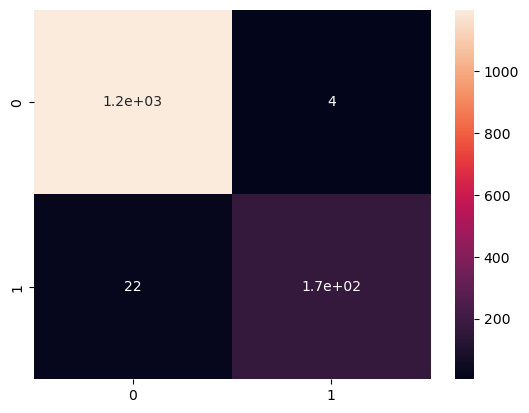

In [9]:
from sklearn.svm import SVC
model_svc = SVC()

vec_cv = CountVectorizer(max_features=150, ngram_range=[1,2])

y = df["target"]
X = df["text"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe1 = Pipeline([ 
                    ("vect", vec_cv),
                    ("model", model_svc)
])

params = ["vec_cv"]

pipe1.fit(X_train, y_train.ravel())
preds = pipe1.predict(X_test)

print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True)


#### Results

Our predictions are pretty good!

## Exercise - Try with TD-IDF

Try the previous prediction with the td-idf vectorizer. Play around with the ngrams if you have time. 

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1198
        spam       0.97      0.85      0.90       195

    accuracy                           0.97      1393
   macro avg       0.97      0.92      0.95      1393
weighted avg       0.97      0.97      0.97      1393



<AxesSubplot:>

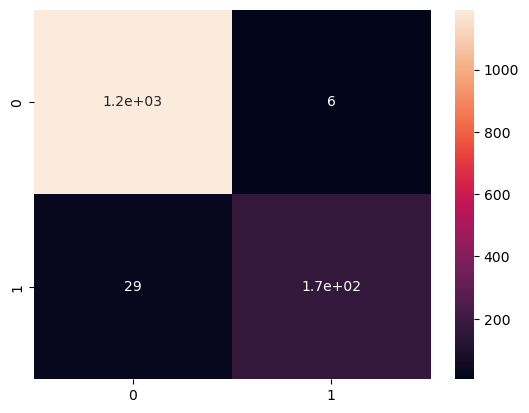

In [10]:
from sklearn.svm import SVC
model_svc = SVC()

vec_tf = TfidfVectorizer(max_features=150)

y = df["target"]
X = df["text"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe1 = Pipeline([ 
                    ("vect", vec_tf),
                    ("model", model_svc)
])

params = ["vec_cv"]

pipe1.fit(X_train, y_train.ravel())
preds = pipe1.predict(X_test)

print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True)

## More Elaborate Language Processing

In the example above we've done a "base" level of modelling - we transform the free text into something that we can process (the bag of words), and we can make predictions from it much like we would with any other one-hot encoded data. This process works fine, and it does deliver some pretty accurate results on our test data. 

To create NLP models that are more functional we can add some layers to our processing of the text to improve our understanding of the nuances of our text. Some things we can do are:
<ul>
<li> <b>Remove Stop Words</b> - common words like "it", "a", "the" are normally not all that useful in predicting the meaning, we can filter these out. 
<li> <b>Stemming</b> - coverting words down to their "stem". E.g. "reasoning" to "reason"
<li> <b>Lemmatization</b> - similar to stemming, but tries to identify the correct stem contextually. E.g. "Operating systems" probably shouldn't become "operate" and "system"
</ul>

In general, stemming increases recall while harming precision. Lemmatization has similar impacts, but tends to be less aggressive, so the effects are smaller. The specific results are highly variable depending on the exact text that is used. Something that uses specific variations of words to mean specific things (e.g. science) is more likely to get no benefit or be negatively impacted - e.g. "conditonally" used in the context of a "conditionally approved loan" is probably not well represented by changing it to "condition". 

### NLTK Library

NLTK is a library that provides a bunch of language processing stuff that we can use such as stop words and tokenizers. We'll leverage it here to make custom tokenizers to incorporate some of those features above. The things we are downloading here are pre-made sets of data, like stop words, and pretrained lists of "root words" that we can use to break words down into their root format. 

<b>Note:</b> the "for package" part there downloads the wordsets to your computer. NLTK has these prebuilt libraries of data that allow for the functions to do the stop words, stemming, and lemmatization. It might take a minute the first time you run it.

## 更精細的語言處理

在上面的示例中，我們已經完成了“基礎”級別的建模——我們將自由文本轉換為我們可以處理的東西（詞袋），

並且我們可以從中做出預測，就像我們對其他任何東西所做的一樣—— 熱編碼數據。 

這個過程運行良好，它確實為我們的測試數據提供了一些非常準確的結果。

為了創建功能更強大的 NLP 模型，我們可以在文本處理中添加一些層，以提高我們對文本細微差別的理解。 我們可以做的一些事情是：
<ul>
<li> <b>刪除停用詞</b> - 像“it”、“a”、“the”這樣的常用詞通常在預測含義方面並不是那麼有用，我們可以過濾掉它們。
<li> <b>詞幹提取</b> - 將單詞隱藏到它們的“詞幹”。 例如。 “推理”到“推理”
<li> <b>詞形還原</b> - 類似於詞幹提取，但嘗試根據上下文識別正確的詞幹。 例如。 “操作系統”可能不應該變成“操作”和“系統”
</ul>

一般來說，詞幹提取會增加召回率，同時會損害準確率。 詞形還原具有類似的影響，但往往不那麼激進，因此影響較小。 

根據所使用的確切文本，具體結果變化很大。 使用特定單詞變體來表示特定事物（例如科學）的事物更有可能得不到任何好處或受到負面影響 - 

例如 在“有條件批准的貸款”的上下文中使用的“有條件地”可能無法通過將其更改為“條件”來很好地表示。

### NLTK 庫

NLTK 是一個庫，它提供了一堆我們可以使用的語言處理工具，例如停用詞和分詞器。 

我們將在這裡利用它來製作自定義分詞器，以合併上面的一些功能。 

我們在這裡下載的是預製的數據集，如停用詞和預訓練的“詞根”列表，我們可以使用它們將詞分解為它們的詞根格式。

<b>注意：</b> 此處的“for package”部分將單詞集下載到您的計算機。 

NLTK 具有這些預構建的數據庫，允許函數執行停用詞、詞幹提取和詞形還原。 第一次運行它可能需要一分鐘。

In [11]:
import nltk

for package in ['stopwords','punkt','wordnet']:
    nltk.download(package)
    
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Elsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Customized Tokenizers

The vecorization libraries in sklearn allow you do specify the function to use to do tokenization. We can use this to include other processing that we'd like as part of the process, such as removing stop words or stemming. The tokenizer functions below can, potentially, contain anything you'd like. As long as the call function returns a list of tokens, it should work. 

<b>Note:</b> if you look up examples, these functions will often be written into one lines, I broke them out so they're hopefully easier to read. They would also likely be much faster if we were to vectorize the code instead of using loops, but again, this is easy to read. 

#### Stop! In the Name of Words. Before you Break my Model.

First, we will try to make a stop word tokenizer. If something is a stop word, we shall leave it out. As noted above, we can build this into the vectorizer, so why do it? This will allow for customizing the stopwords used - some applications may have a different usage of words, so changing stopwords makes sense. It is also a super fun exercise! 

This is also the most simple example we can try :)

### 定制分詞器

sklearn 中的矢量化庫允許您指定用於進行標記化的函數。 我們可以使用它來包括我們希望作為流程一部分的其他處理，例如刪除停用詞或詞幹提取。 

下面的分詞器函數可能包含您想要的任何內容。 只要調用函數返回標記列表，它就應該可以工作。

<b>注意：</b>如果您查找示例，這些函數通常會被寫成一行，我將它們分開，希望它們更容易閱讀。 

如果我們將代碼向量化而不是使用循環，它們也可能會快得多，但同樣，這很容易閱讀。

＃＃＃＃ 停止！ 以文字之名。 在你破壞我的模型之前。

首先，我們將嘗試製作一個停用詞分詞器。 如果某個東西是停用詞，我們將把它去掉。 

如上所述，我們可以將其構建到矢量化器中，那麼為什麼要這樣做呢？ 

這將允許自定義使用的停用詞 - 某些應用程序可能有不同的單詞用法，因此更改停用詞是有意義的。 這也是一項超級有趣的運動！

In [12]:
class swTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(tok)
        return filtered_tok

### Stemming and Lemmatization

Stemming and lemmatization are similar - they both aim to break words down to their "root". For example, the word "shoes" probably has the same meaning as the word "shoe" for our purposes. Each approaches this in a slightly different way, and to understand that we need to take a look at the conecpt of similarity, which we'll look at more next time. 

#### Similarity

When processing text, we can think of things being similar in two different ways - similar text or similar meaning - or lexical and semantic similarity. Things that are lexically similar use similar words, things that are semantically similar have similar meanings, even if the words are different. The stemming techniques here aren't explicit comparisons of those similarity types, but they follow the same concepts. Stemming breaks words down to their lexical root, lemmatization tries to find the semantic root.

#### Stemming

Stemming is the most simple, it just removes common prefixes and suffixes to extract the root of the word. 

### 詞乾化和詞形還原

詞幹提取和詞形還原相似——它們都旨在將單詞分解為它們的“詞根”。 例如，對於我們的目的，“shoes”這個詞可能與“shoe”這個詞具有相同的含義。 

每個人都以略有不同的方式來處理這個問題，要理解我們需要看一下相似性的概念，我們下次會詳細介紹。

####相似度

在處理文本時，我們可以通過兩種不同的方式來思考事物的相似性——相似的文本或相似的含義——或者詞彙和語義的相似性。 

詞彙相似的事物使用相似的詞，語義相似的事物具有相似的含義，即使這些詞不同。 

這裡的詞幹提取技術並不是對這些相似類型的明確比較，但它們遵循相同的概念。 詞乾化將單詞分解為詞根，詞形還原試圖找到語義根。

#### 詞幹提取

Stemming 是最簡單的，它只是去除常見的前綴和後綴來提取單詞的詞根。

In [13]:
class stemTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import SnowballStemmer
        self.stemmer = SnowballStemmer(language='english')
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(self.stemmer.stem(tok))
        return filtered_tok

#### Lemmatization

Lemmatization is slightly more sophisticated, it attempts to find the semantic root, called the lemma, of a word using a search of a dictionary (we provide one from NLTK). For example, the lemma of "better" is "good". This is a "smarter" approach that the more simple stemming function above, but it is also more complex and slower.

In [14]:
class lemmaTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import WordNetLemmatizer
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(self.lemmatizer.lemmatize(tok))
        return filtered_tok

### Predictions with More Processing and Grid Search

We can try to see which processing setup works best, the winner will depend on how the text is written. 

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=1500, norm='l1',
                                 tokenizer=<__main__.lemmaTokenizer object at 0x000001B57B6A5970>)),
                ('model', SVC())])
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       1.00      0.84      0.92       187

    accuracy                           0.98      1393
   macro avg       0.99      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393



<AxesSubplot:>

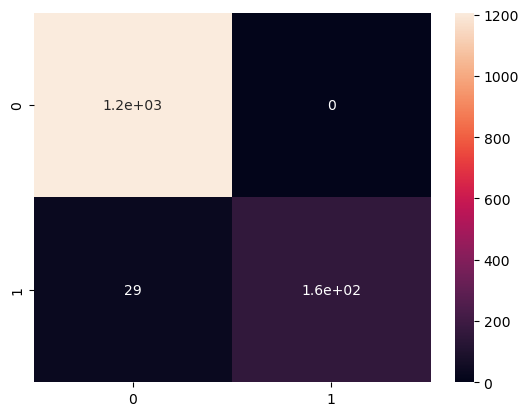

In [15]:
vec_tf = TfidfVectorizer()

y = df["target"]
X = df["text"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe2 = Pipeline([ 
                    #("vect", vec_cv),
                    ("vect", vec_tf),
                    ("model", model_svc)
])

params = {"vect__max_features":[100,500,1000,1500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            "vect__norm":["l1","l2"]
            }

grid = GridSearchCV(estimator  = pipe2, 
                               param_grid = params, 
                               scoring    = "balanced_accuracy",
                               cv         = 5,
                               n_jobs     =-1)

grid.fit(X_train, y_train.ravel())
best = grid.best_estimator_
preds = best.predict(X_test)
print(best)
print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True)

##### Results

We are accurate! 

## Exercise

Categorize the following newsgroups. The data are posts from different newgroup boards. Try to categorize the data in either the atheism or religion groups. 

In [16]:
from sklearn.datasets import fetch_20newsgroups
remove = ("headers", "footers", "quotes")
categories = ["alt.atheism", "talk.religion.misc"]

data_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42, remove=remove)

data_test = fetch_20newsgroups(
    subset="test", categories=categories, shuffle=True, random_state=42, remove=remove)

X_train3 = data_train.data
y_train3 = data_train.target
X_test3 = data_test.data
y_test3 = data_test.target

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_features=2500,
                                 tokenizer=<__main__.lemmaTokenizer object at 0x000001B6964AE490>)),
                ('model', SVC())])
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       319
           1       0.65      0.47      0.55       251

    accuracy                           0.66       570
   macro avg       0.66      0.64      0.64       570
weighted avg       0.66      0.66      0.65       570



<AxesSubplot:>

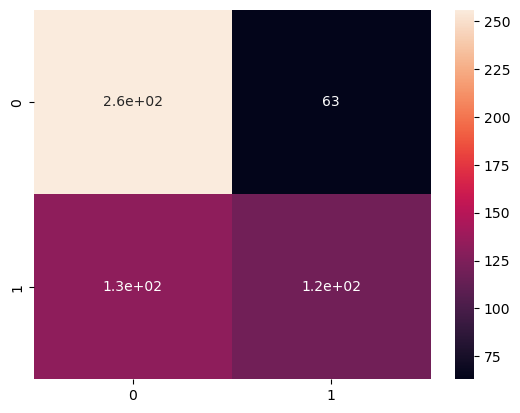

In [17]:
vec_tf3 = TfidfVectorizer()
model_svc3 = SVC()

pipe3 = Pipeline([ 
                    ("vect", vec_tf3),
                    ("model", model_svc3)
])

params3 = {"vect__max_features":[100,500,1000,1500,2000,2500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            "vect__norm":["l1","l2"]
            }

grid3 = GridSearchCV(estimator  = pipe3, 
                               param_grid = params3, 
                               scoring    = "balanced_accuracy",
                               cv         = 5,
                               n_jobs     =-1)

grid3.fit(X_train3, y_train3)
best3 = grid3.best_estimator_
preds3 = best3.predict(X_test3)
print(best3)
print(classification_report(y_test3, preds3))
sns.heatmap(confusion_matrix(y_test3, preds3), annot=True)